In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec  # for unequal plot boxes

%matplotlib inline

import lax 
from lax.lichens import sciencerun1
from pax import units
import hax
hax.init(pax_version_policy='6.10.1')
         #minitree_paths=['.', '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0'])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/seaborn-0.8.1-py3.4.egg/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Selection of dataset

In [2]:
datasets = hax.runs.datasets
datasets = hax.runs.tags_selection(datasets, include=['cathode_-5kV', 'cathode_-5kv'],
                                   exclude=['bad', 'messy', 'test', '*lash*', 'source_opening'])

datasets = datasets[datasets['source__type'] == 'Kr83m']

# Select only runs of an hour or more
datasets['run_time_s'] = pd.to_timedelta((datasets.end) - pd.to_datetime(datasets.start)).dt.seconds
datasets = datasets[datasets.run_time_s > 3600]

# Only select runs in a particular date-range (date MM/DD/YY)
datasets = datasets[(datasets.start > pd.to_datetime('06/10/18', format = '%d/%m/%y')) &
              (datasets.end < pd.to_datetime('16/10/18',format = '%d/%m/%y'))] # only newer runs

# datasets
print('Selected %d datasets' % len(datasets))
#print('\nThe total runtime (days): ' ,datasets.run_time_s.sum()/(60*60*24))
#print('\n', hax.runs.count_tags(datasets), '\n')


Selected 22 datasets


In [3]:
# minitrees
data = hax.minitrees.load(datasets.name, ['CorrectedDoubleS1Scatter', 'Basics'])
no_cuts_data = data
no_cuts_data = no_cuts_data.dropna(subset=['s1_b', 's1_a'])
print('\n', data.columns.values)


 ['cs1_a' 'cs1_a_no_field_corr' 'cs1_b' 'cs1_b_int_b'
 'cs1_b_int_b_no_field_corr' 'cs1_b_no_field_corr' 'cs2_a' 'cs2_a_bottom'
 'cs2_a_top' 'drift_time' 'ds_s1_b_n_distinct_channels' 'ds_s1_dt'
 'ds_second_s2' 'event_number' 'int_a_drift_time' 'int_a_r_3d_nn'
 'int_a_r_correction_3d_nn' 'int_a_r_nn' 'int_a_x_3d_nn' 'int_a_x_nn'
 'int_a_x_pax' 'int_a_y_3d_nn' 'int_a_y_nn' 'int_a_y_pax' 'int_a_z_3d_nn'
 'int_a_z_correction_3d_nn' 'int_a_z_observed' 'int_a_z_pax'
 'int_b_drift_time' 'int_b_r_3d_nn' 'int_b_r_correction_3d_nn' 'int_b_r_nn'
 'int_b_x_3d_nn' 'int_b_x_nn' 'int_b_x_pax' 'int_b_y_3d_nn' 'int_b_y_nn'
 'int_b_y_pax' 'int_b_z_3d_nn' 'int_b_z_correction_3d_nn'
 'int_b_z_observed' 'int_b_z_pax' 'largest_coincidence' 'largest_other_s1'
 'largest_other_s2' 'largest_unknown' 'largest_veto' 'run_number' 's1'
 's1_a' 's1_a_area_fraction_top' 's1_a_center_time' 's1_area_fraction_top'
 's1_b' 's1_b_area_fraction_top' 's1_b_center_time'
 's1_int_a_xyz_correction_nn_fdc_3d'
 's1_int_a_xyz_t

### Cuts on dataset (https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:analysis:sciencerun1:elifetime)

In [4]:
# Reject bkg events from pileup
data = data[(data['s1_b_center_time']-data['s1_a_center_time'] > 100) &
           (data['s1_b_center_time']-data['s1_a_center_time'] < 2000)]
# Reject afterpulses events
data = data[(data['ds_s1_b_n_distinct_channels']>3) & 
           (data['ds_s1_b_n_distinct_channels']<30)]
# fiducial volume
data = hax.cuts.selection(data, data['int_a_r_nn'] < 30)
data = hax.cuts.selection(data, data['int_a_z_pax'] > -92.9) 
data = hax.cuts.selection(data, data['int_a_z_pax'] < -9)

Unnamed selection: 5655 rows removed (56.15% passed)
Unnamed selection: 690 rows removed (90.47% passed)
Unnamed selection: 995 rows removed (84.81% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [5]:
cut_history = hax.cuts.history(data)
cutL = ['CutDelayTime','CutDistinctChannels','CutFid1T']
cut_history.selection_desc = cutL
cut_history

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,CutDelayTime,12897,7242,5655,0.561526,0.561526
1,CutDistinctChannels,7242,6552,690,0.904722,0.508025
2,CutFid1T,6552,5557,995,0.848138,0.430875


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


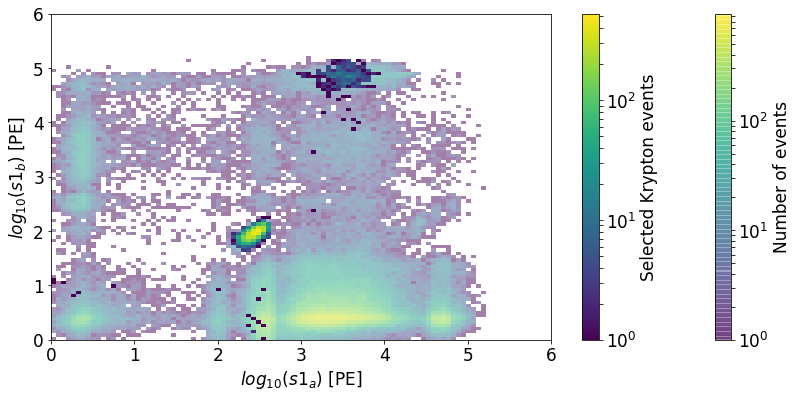

In [6]:
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})
plt.hist2d(np.log10(no_cuts_data['s1_a']), np.log10(no_cuts_data['s1_b']), bins=(100,100), range=((0,6),(0,6)),
           norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 0.5)
plt.colorbar(label='Number of events')
plt.hist2d(np.log10(data['s1_a']), np.log10(data['s1_b']), bins=(100,100), range=((0,6),(0,6)),
                                   norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)
ax = plt.gca()
plt.colorbar(label='Selected Krypton events')
plt.xlabel('$log_{10}(s1_a)$ [PE]')
plt.ylabel('$log_{10}(s1_b)$ [PE]')
plt.savefig('figures/selected_data.png', bbox_inches='tight')

plt.show()

### The previous plot show an excess of data in the upper right part that is not expected since s1(0) is bigger than s1(1). Hence, these data are deleted from the analysis. Be carefull with the next cut.

In [7]:
# Remove those data that are not kripton
data = hax.cuts.selection(data, data['s1_b'] < data['s1_a'])
cut_history = hax.cuts.history(data)
cutL = ['CutDelayTime','CutDistinctChannels','CutFid1T', 'CutNoKrData']
cut_history.selection_desc = cutL
cut_history

Unnamed selection: 394 rows removed (92.91% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,CutDelayTime,12897,7242,5655,0.561526,0.561526
1,CutDistinctChannels,7242,6552,690,0.904722,0.508025
2,CutFid1T,6552,5557,995,0.848138,0.430875
3,CutNoKrData,5557,5163,394,0.929098,0.400326


--Parameters-- 
 [ 960.30038516  225.69553531] 
--Covariance matrix-- 
 [[ 10823.980371     -800.22593732]
 [  -800.22593732     60.3181017 ]]
Red chi squared:  0.0541990105538

-- Kr83m 7/2+ lifetime of --
156.440223966  +/-  5.38330881125  ns
Percentage error:  3.44112829473 %


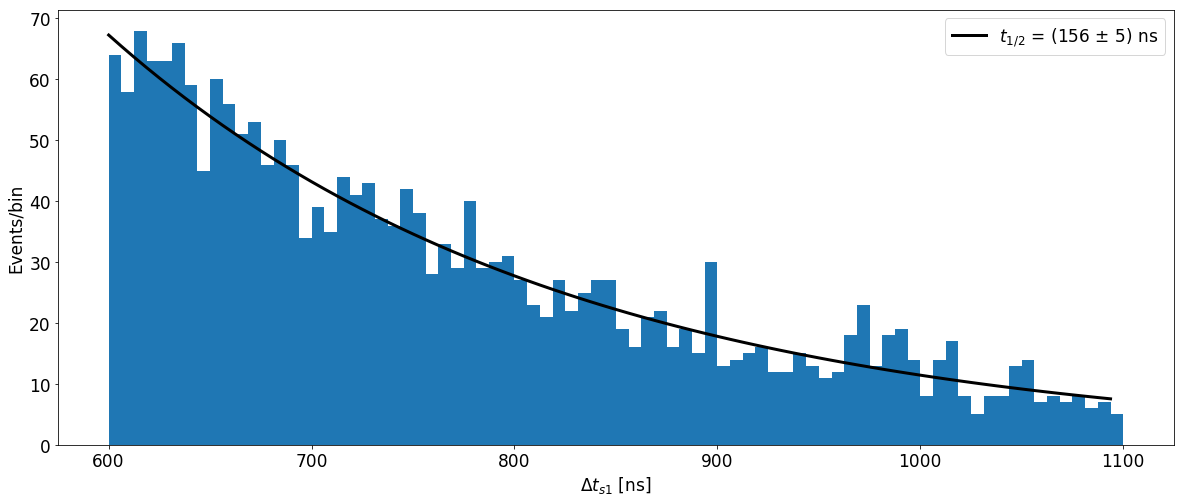

In [8]:
fig = plt.figure(1, figsize=(20,8))
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})
data_tmp = data.dropna(subset=['ds_s1_dt'])
n, bins, _ = plt.hist(data_tmp['ds_s1_dt'], bins = (80), range=(600, 1100), 
         histtype='stepfilled')

def expo(t, N, tau):
    return N * np.exp(-t/tau)   

init = [3*pow(10,3),155]
popt, pcov = curve_fit(expo, bins[:len(bins)-1], n[:], maxfev=1000, p0=init)
plt.plot(bins[:len(bins)-1], expo(bins[:len(bins)-1], *popt), linestyle='-', linewidth=3, marker=' ', color='black')
plt.xlabel('$\Delta t_{s1}$ [ns]')
plt.ylabel('Events/bin')
plt.legend(['$t_{1/2}$ = (156 $\pm$ 5) ns'])
plt.savefig('figures/kr_lifetime.png', bbox_inches='tight')

# Unpack fitting parameters and their relative erros
N, tau = popt
dN, dtau = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
# Calculate residuals and reduced chi squared
resids = n[:] - expo(bins[:len(bins)-1], *popt)
redchisqr = ((resids/expo(bins[:len(bins)-1], *popt))**2).sum()/float(len(bins[:len(bins)-1])-2)
print('--Parameters-- \n', popt, '\n--Covariance matrix-- \n', pcov)
print('Red chi squared: ', redchisqr)
print('\n-- Kr83m 7/2+ lifetime of --')
print(np.log(2)*tau, ' +/- ', np.log(2)*dtau , ' ns')
print('Percentage error: ', dtau/tau*100, '%')
plt.show()

### --------- Electron life time ---------

In [9]:
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})
plt.plot(data['int_a_drift_time']/1000, data['s2_a_bottom'], linestyle='', marker='o', markersize=1)
plt.ylim(0,12000)
plt.xlim(0,900)
plt.xlabel('drift time [us]')
plt.ylabel('s2 [PE]')
plt.tight_layout()
plt.close()

Unnamed selection: 20 rows removed (99.61% passed)
Unnamed selection: 4 rows removed (99.92% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


--Parameters-- 
 [ 6932.5427741    834.30553221] 
--Covariance matrix-- 
 [[ 998.3804509  -202.16830063]
 [-202.16830063   52.21270721]]
Red chi squared:  0.00016249851078
--Electron life time--
In Xenon1T: 467 +/- 5 us
Post SR1:  834.305532209  +/-  7.22583609064  us
Percentage error:  0.866089916905 %


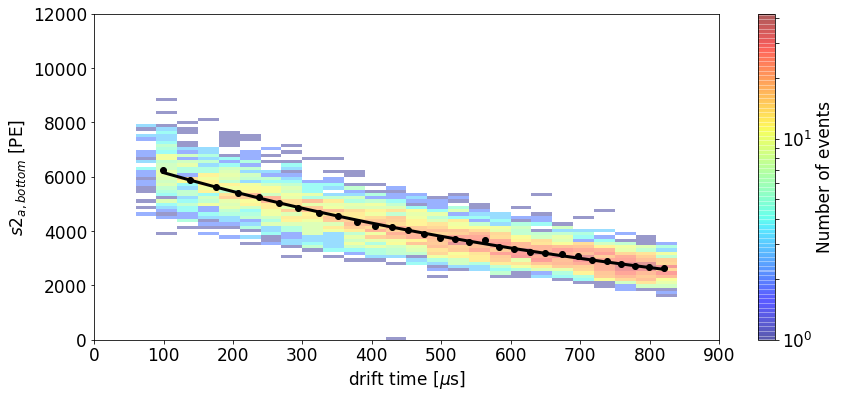

In [10]:
# Selection of fitting data
data_Elf_new = data[['int_a_drift_time', 's2_a_bottom']]
data_Elf_new = hax.cuts.selection(data_Elf_new, data_Elf_new['s2_a_bottom'] > 2000)
data_Elf_new = hax.cuts.selection(data_Elf_new, data_Elf_new['s2_a_bottom'] < 8000)
data_Elf_new = hax.cuts.selection(data_Elf_new, data_Elf_new['int_a_drift_time'] > 60*units.us)
data_Elf_new = hax.cuts.selection(data_Elf_new, data_Elf_new['int_a_drift_time'] < 840*units.us)

hist, xbins, ybins, _ = plt.hist2d(data['int_a_drift_time']/1000, data['s2_a_bottom'], bins=(30,100), 
                                   range=((0,900), (0,12000)), cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 0.4)
plt.colorbar(label='Number of events')
plt.xlabel('drift time [$\mu$s]')
plt.ylabel('$s2_{a,bottom}$ [PE]')
#print('hist: ', hist, '\nxbins: ', xbins,  '\nybins: ', ybins)

data_Elf_new_sorted = data_Elf_new.sort_values(by = ['int_a_drift_time'], ascending = True).reset_index(drop = True)
L = int(len(data_Elf_new_sorted.int_a_drift_time)/30)
#print(data_Elf_sorted, L)
t = []
s2 = []
for i in range(0,30):
    t.append((data_Elf_new_sorted.loc[L*(i+1), 'int_a_drift_time']+data_Elf_new_sorted.loc[L*(i), 'int_a_drift_time'])/2)
    t[i] = t[i]/1000 #change of unity ns->us
    s2.append(data_Elf_new_sorted.loc[L*(i):L*(i+1), 's2_a_bottom'].median())

# Electron Life Time model
def expo(t, N, tau):
    return N * np.exp(-t/tau)   

plt.plot(t, s2, linestyle=' ', marker='o', color='black')
init = [pow(10,3),700]
popt, pcov = curve_fit(expo, np.asarray(t), s2, maxfev=1000, p0=init)
plt.plot(t, expo(np.asarray(t), *popt), linestyle='-', linewidth=3, marker=' ', color='black')
plt.savefig('figures/electron_life_time.png', bbox_inches='tight')

# Unpack fitting parameters and their relative erros
N, tau = popt
dN, dtau = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
# Calculate residuals and reduced chi squared
resids = s2 - expo(np.asarray(t), *popt)
redchisqr = ((resids/expo(np.asarray(t), *popt))**2).sum()/float(len(t)-2)
print('--Parameters-- \n', popt, '\n--Covariance matrix-- \n', pcov)
print('Red chi squared: ', redchisqr)
print('--Electron life time--\nIn Xenon1T: 467 +/- 5 us')
print('Post SR1: ', tau, ' +/- ', dtau , ' us')
print('Percentage error: ', dtau/tau*100, '%')

### --------- Correction through electron life time ---------

In [11]:
def xi(cS2, S2, t, tau):
    xi = (cS2/S2)*np.exp(-t/tau)
    xi = 1
    return xi
def Elf_correction(S2, t, tau, xi):
    return S2 * xi * np.exp(t/tau)

data['xi'] = xi(data['cs2_a_bottom'], data['s2_a_bottom'], data['int_a_drift_time']/1000, tau)
data['cs2_a_bottom_Elf'] = Elf_correction(data['s2_a_bottom'], data['int_a_drift_time']/1000, tau, data['xi'])
#print(data[['cs2_a_bottom_Elf', 'cs2_a_bottom', 'xi']])

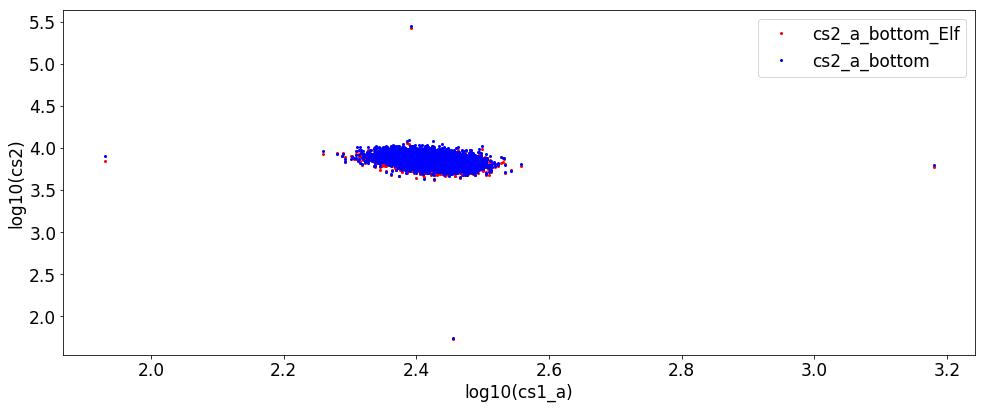

In [12]:
plt.plot(np.log10(data['cs1_a']), np.log10(data['cs2_a_bottom_Elf']), 
         linestyle='', marker='o', markersize=2, color='red')
plt.plot(np.log10(data['cs1_a']), np.log10(data['cs2_a_bottom']), 
         linestyle='', marker='o', markersize=2, color='blue')
plt.legend(loc='best')
plt.xlabel('log10(cs1_a)')
plt.ylabel('log10(cs2)')
plt.tight_layout()

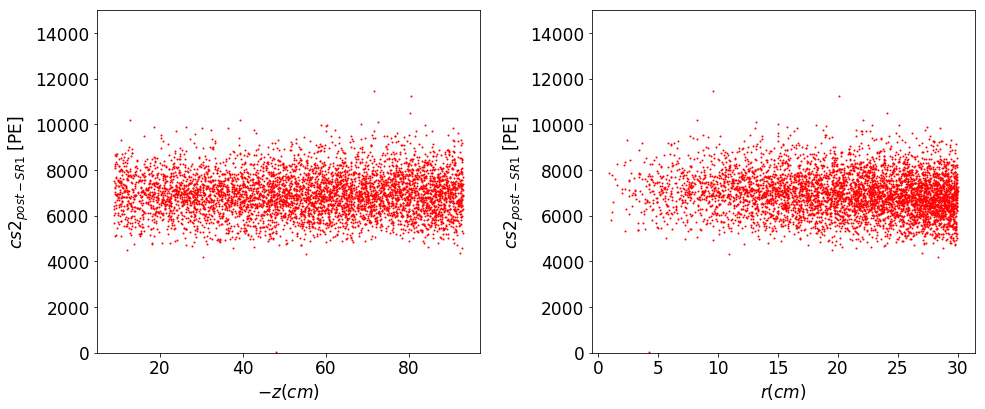

In [13]:
plt.subplot(121)
plt.plot(-data['int_a_z_pax'], data['cs2_a_bottom_Elf'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(0,15000)
plt.xlabel('$-z (cm)$')
plt.ylabel('$cs2_{post-SR1}$ [PE]')
plt.subplot(122)
plt.plot(data['int_a_r_nn'], data['cs2_a_bottom_Elf'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(0,15000)
plt.xlabel('$r (cm)$')
plt.ylabel('$cs2_{post-SR1}$ [PE]')

plt.tight_layout()
plt.savefig('figures/corrected_data_post-SR1.png', bbox_inches='tight')

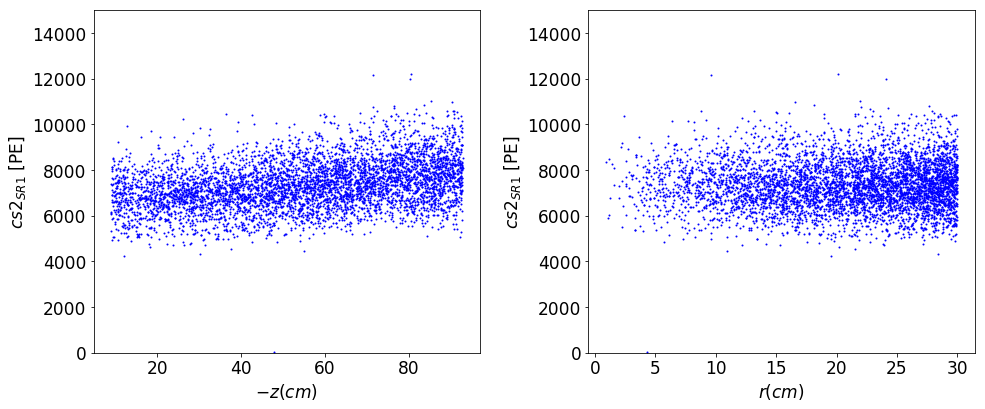

In [14]:
plt.subplot(121)
plt.plot(-data['int_a_z_pax'], data['cs2_a_bottom'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(0,15000)
plt.xlabel('$-z (cm)$')
plt.ylabel('$cs2_{SR1}$ [PE]')
plt.subplot(122)
plt.plot(data['int_a_r_nn'], data['cs2_a_bottom'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(0,15000)
plt.xlabel('$r (cm)$')
plt.ylabel('$cs2_{SR1}$ [PE]')

plt.tight_layout()
plt.savefig('figures/corrected_data_SR1.png', bbox_inches='tight')

### --------- Slope after correction ---------

Unnamed selection: 1 rows removed (99.98% passed)
Unnamed selection: 1 rows removed (99.98% passed)
51.61
--Parameters-- 
a: ( 0.528723883563  +/-  0.618395627599 ) b: ( 

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


6897.05852055  +/-  36.8244910385 )
--Covariance matrix-- 
 [[  3.82413152e-01  -2.09603434e+01]
 [ -2.09603434e+01   1.35604314e+03]]
Red chi squared:  1.00434510091


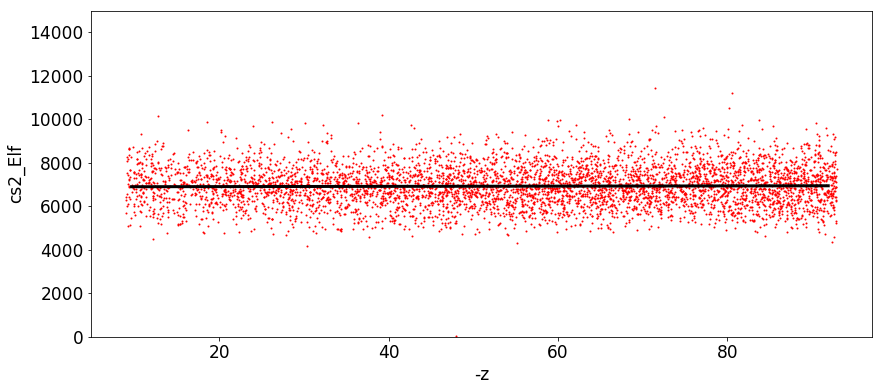

In [15]:
plt.plot(-data['int_a_z_pax'], data['cs2_a_bottom_Elf'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(0,15000)
plt.xlabel('-z')
plt.ylabel('cs2_Elf')

data_time = data[['cs2_a_bottom_Elf', 'int_a_z_pax']]
data_time = data_time.abs()
data_time = hax.cuts.selection(data_time, data_time['cs2_a_bottom_Elf'] > 4000)
data_time = hax.cuts.selection(data_time, data_time['cs2_a_bottom_Elf'] < 12000)
#print(data_time)

data_sorted = data_time.sort_values(by = ['int_a_z_pax'], ascending = True).reset_index(drop = True)
L = int(len(data_sorted.int_a_z_pax)/100)
print(len(data_sorted)/100)
z = []
s2 = []
for i in range(0,100):
    z.append((data_sorted.loc[L*(i+1), 'int_a_z_pax']+data_sorted.loc[L*(i), 'int_a_z_pax'])/2)
    s2.append(data_sorted.loc[L*(i):L*(i+1), 'cs2_a_bottom_Elf'].median())
    
def pol1(x, a , b):
    return a*x + b
init=[10,7000]
popt, pcov = curve_fit(pol1, np.asarray(z), s2, maxfev=1000, p0=init)
plt.plot(z, pol1(np.asarray(z), *popt), linestyle='-', linewidth=3, marker=' ', color='black')
plt.savefig('figures/s2_elf_correction.png', bbox_inches='tight')

# Unpack fitting parameters and their relative erros
a, b = popt
da, db = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
# Calculate residuals and reduced chi squared
resids = z - pol1(np.asarray(z), *popt)
redchisqr = ((resids/pol1(np.asarray(z), *popt))**2).sum()/float(len(z)-2)
print('--Parameters-- \na: (', a, ' +/- ', da, ') b: (', b, ' +/- ', db, ')\n--Covariance matrix-- \n', pcov)
print('Red chi squared: ', redchisqr)

### --------- Drift velocity ---------

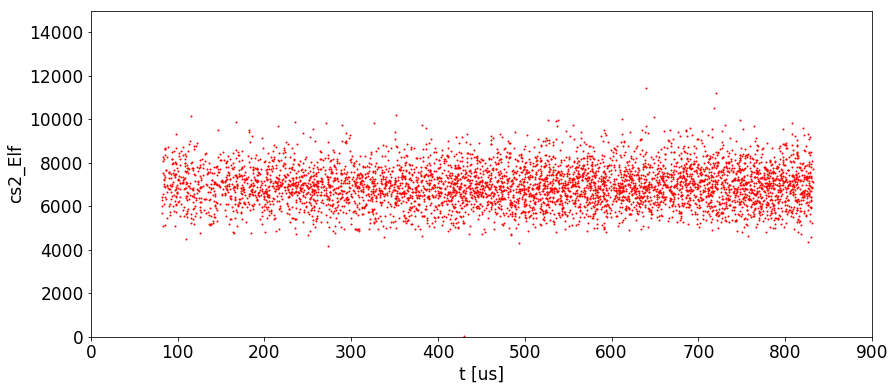

Unnamed selection: 124456 rows removed (14.01% passed)
Unnamed selection: 15522 rows removed (89.28% passed)
------------------------------------
Max drift time:  839.9996875  us
Drift velocity =  1.15000042783 mm/us
In XENON1T with -5kV as cathode voltage was: 1.1224 nn/us
------------------------------------


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [16]:
data_velocity = no_cuts_data
data_velocity['xi'] = xi(data_velocity['cs2_a_bottom'], data_velocity['s2_a_bottom'], data_velocity['int_a_drift_time']/1000,
                         tau)
data_velocity['cs2_a_bottom_Elf'] = Elf_correction(data_velocity['s2_a_bottom'], data_velocity['int_a_drift_time']/1000,
                                                   tau, data['xi'])
plt.plot(data_velocity['int_a_drift_time']/1000, data_velocity['cs2_a_bottom_Elf'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(0,15000)
plt.xlim(0,900)
plt.xlabel('t [us]')
plt.ylabel('cs2_Elf')
plt.show()
time = hax.cuts.selection(data_velocity, data_velocity['int_a_drift_time'] > 800*10**3)
time = hax.cuts.selection(data_velocity, data_velocity['int_a_drift_time'] < 840*10**3)
time_max = time['int_a_drift_time'].max()
print('------------------------------------')
print('Max drift time: ', time_max/10**3, ' us')
velocity = (96.6*10)/(time_max/10**3)
print('Drift velocity = ', velocity, 'mm/us')
print('In XENON1T with -5kV as cathode voltage was: 1.1224 nn/us')
print('------------------------------------')

### --------- Uniformity ---------

In [17]:
data_uniformity = no_cuts_data
# Reject bkg events from pileup
data_uniformity = data_uniformity[(data_uniformity['s1_b_center_time']-data_uniformity['s1_a_center_time'] > 100) &
           (data_uniformity['s1_b_center_time']-data_uniformity['s1_a_center_time'] < 2000)]

# Reject afterpulses events
data_uniformity = data_uniformity[(data_uniformity['ds_s1_b_n_distinct_channels']>3) & 
           (data_uniformity['ds_s1_b_n_distinct_channels']<30)]
# Drift time
data_uniformity = hax.cuts.selection(data_uniformity, data_uniformity['int_a_drift_time'] < time_max)

# Otherwise ERROR 
data_uniformity = hax.cuts.selection(data_uniformity, data_uniformity['int_a_z_pax'] < -1)

# Electron life time correction
data_uniformity['xi'] = xi(data_uniformity['cs2_a_bottom'], data_uniformity['s2_a_bottom'], 
                           data_uniformity['int_a_drift_time']/1000, tau)
data_uniformity['cs2_a_bottom_Elf'] = Elf_correction(data_uniformity['s2_a_bottom'], 
                                                     data_uniformity['int_a_drift_time']/1000, tau, data_uniformity['xi'])

# Note
#data_uniformity = data_uniformity[(data_uniformity['cs2_a_bottom_Elf'] > 152) &
#           (data_uniformity['cs2_a_bottom_Elf'] < 100000 )]
#data_uniformity = data_uniformity[(data_uniformity['cs1_a'] > 0) &
#           (data_uniformity['cs1_a'] < 1000 )]


Unnamed selection: 849 rows removed (93.42% passed)
Unnamed selection: 987 rows removed (91.81% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


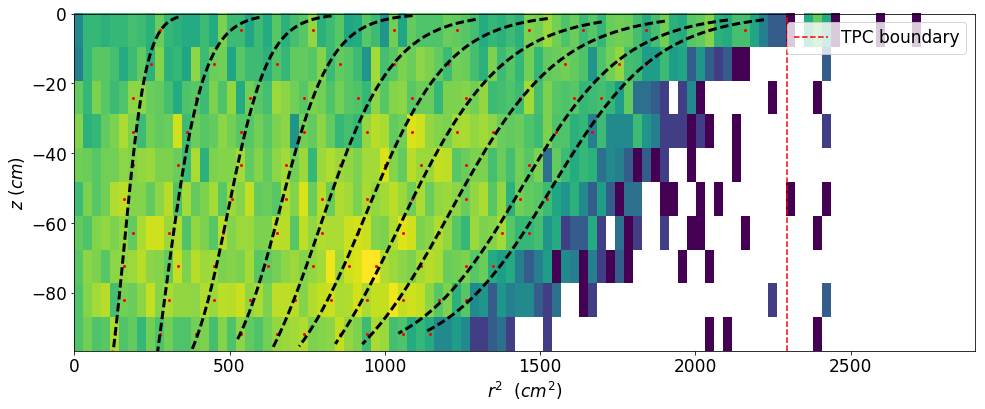

In [74]:
def r_Map(x, N, a, b):
    return -N*(1/(1+np.exp(a*(x+ b))))

data_uniformity = data_uniformity.sort_values(by = ['int_a_z_pax'], ascending = False).reset_index(drop = True)
L = int(len(data_uniformity.int_a_z_pax)/10)
hist, xbins, ybins, _ = plt.hist2d(data_uniformity['int_a_r_nn']**2, data_uniformity['int_a_z_pax'], bins=(100,10), 
                                   range=((0,2900),(-96.6, 0)), norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 1)
NaNs = np.isnan(hist)
hist[NaNs] = 0
Nans = np.isnan(hist)
hist_transpose = hist.transpose() 

# hist -> (100, 10) entrate sull'asse z al variare di r 
# hist_transpose -> (10,100) entrate sull'asse r al variare di z
# hist: primo riga r=0, secondo riga r=1, ... hist_traspose: primo riga z=-100, seconda riga z=-90, ...

xbins_center = [(xbins[i+1]+xbins[i])/2 for i in range(0, len(xbins)-1)]
ybins_center = [(ybins[i+1]+ybins[i])/2 for i in range(0, len(ybins)-1)]
perc_R = [(47.9**2)*0.1*(j+1) for j in range(0,9)] + [0.94*(47.9**2)]
r = np.zeros((10,10), dtype=float)
scale = np.zeros((10,10), dtype=float)
pos_z = np.zeros((10,10), dtype=float)
coeff = np.zeros((10,3), dtype=float)

k = 0
row = 0
col = 0
for l in range(0,10):
    #print(hist_transpose[l])
    Tot = hist_transpose[l].sum()
    tmp1 = [Tot*0.1*(j+1) for j in range(0,9)] + [0.94*Tot]
    #print(Tot, '\n\n', tmp1)
    for i in range(0, len(hist_transpose[l])):
        tmp2 = hist_transpose[l,:i].sum()
        if tmp2 > tmp1[k]:
            r[row,k] = xbins_center[i-1] #dato il bin su z, r[i] indica il raggio entro il quale ci sono 10%, 20%, ... dati
            pos_z[row,k] = i-1
            #print(pos_z[row,k])
            k=k+1         
        if k==10:
            break;
    k=0
    row=row+1
    tmp1 = 0
    tmp2 = 0
r_new = r.transpose() 

# r -> dato il bin z, ha come entrate i raggi**2 entro il quale entrano il 10%, 20%,... dei dati
# r_new -> ha come entrate i raggi**2 delle curve al 10%, 20%,... dei dati
# si parte sempre dal fondo, duqnue la prima riga di r è il bin a z = -90. Ovviamente la prima riga di r_new sono i dati
# della curva al 10%!

for i in range(0,10):
    scale[i] = np.sqrt(r[i]/np.asarray(perc_R)) #dato il bin su z, scale contiene il fattore moltiplicativo tra r_obs -> r_true
    #print(scale[i], ' = ', r[i], ' / ', np.asarray(perc_R))
    plt.plot(r_new[i], ybins_center, linestyle=' ', marker='o', markersize=2, color='red')
    init = [90, 10**(-3), -1000]
    popt, pcov = curve_fit(r_Map, r_new[i], ybins_center, maxfev=1000, p0=init)
    start = r_new[i,0] - 15
    stop = r_new[i,9] + 60
    x = np.linspace(stop, start, 50)
    plt.plot(x, r_Map(x, *popt), linestyle='--', linewidth=3, marker=' ', color='black')
    # Unpack fitting parameters and their relative erros
    N, a, b = popt
    dN, da, db = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
    # Calculate residuals and reduced chi squared
    resids = ybins_center - r_Map(r_new[i], *popt)
    redchisqr = ((resids/r_Map(r_new[i], *popt))**2).sum()/float(len(r_new[i])-3)
    coeff[i] = popt
    #print('--Parameters-- \nN: (', N,' +/- ', dN, ') a: (', a, ' +/- ', da, ') b: (', b, ' +/- ', db, ')\n--Covariance matrix-- \n', pcov)
    #print('Red chi squared: ', redchisqr)
np.savetxt("/home/gvolta/Desktop/Function/Field_Correction/coefficients", coeff,
               newline="\n", header = ' N \t a \t a' )    
plt.axvline(x=47.9**2, color='red', ls='--', label='TPC boundary')
plt.ylim(-96.6,0.0)
plt.xlabel('$r^2$  ($cm^2$)')
plt.ylabel('$z$ $(cm)$')
plt.legend(loc='best')
plt.savefig('figures/field_distortion.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [37]:
'''print(scale)
scale_1 = np.loadtxt('scale.txt')
print(scale_1)'''

"print(scale)\nscale_1 = np.loadtxt('scale.txt')\nprint(scale_1)"

###  --------- Be careful to run ---------

In [75]:
data_uniformity = data_uniformity.sort_values(by = ['int_a_z_pax'], ascending = True).reset_index(drop = True)
data_uniformity['int_a_r_correct'] = data_uniformity['int_a_r_nn']
data_uniformity['int_a_r_nn_squared'] = data_uniformity['int_a_r_nn']**2
r_zero = np.zeros((10,1), dtype=float)
r_zero = np.hstack((r_zero, r))

In [ ]:
'''k=0
j=0
control = 0
for i in range(0, len(data_uniformity)):
    print('\n', i)
    while control == 0: #trova il bin di z_pax e copia la variabile che itera k -> row
        if data_uniformity['int_a_z_pax'].iloc[i] <= ybins[k+1] and data_uniformity['int_a_z_pax'].iloc[i] >= ybins[k]:
            row = k
            control = 1
        elif k==10:
            break;
        else:
            k=k+1
    control = 0
    while control == 0: #definito il row, devo trovare dove appartiene r_nn (10% dei dati, 20% de dati,...). j -> col
        if j==10 and data_uniformity['int_a_r_nn_squared'].iloc[i] > r_zero[k,j-1]:
            col = j-1
            data_uniformity['int_a_r_correct'].iloc[i] = data_uniformity['int_a_r_nn'].iloc[i]/scale[row, col]
            break
        if data_uniformity['int_a_r_nn_squared'].iloc[i] < r_zero[k,j+1] and data_uniformity['int_a_r_nn_squared'].iloc[i] > r_zero[k,j]:    
            col = j
            data_uniformity['int_a_r_correct'].iloc[i] = data_uniformity['int_a_r_nn'].iloc[i]/scale[row, col]
            control = 1 
        else:
            j=j+1
    j=0
    k =0
    control = 0

data_uniformity[['int_a_z_pax', 'int_a_r_nn', 'int_a_r_correct']].to_csv('corretto_94', sep='\t', 
                                                                         encoding='utf-8', index=False)'''

### --------- Read from cvs file and compare ---------

In [ ]:
data_uniformity_csv = pd.read_csv('corretto_94',  sep='\t', delimiter=None, header='infer')
data_uniformity['int_a_r_correct'] = data_uniformity_csv['int_a_r_correct']
data['int_a_r_correct'] = data_uniformity_csv['int_a_r_correct']

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


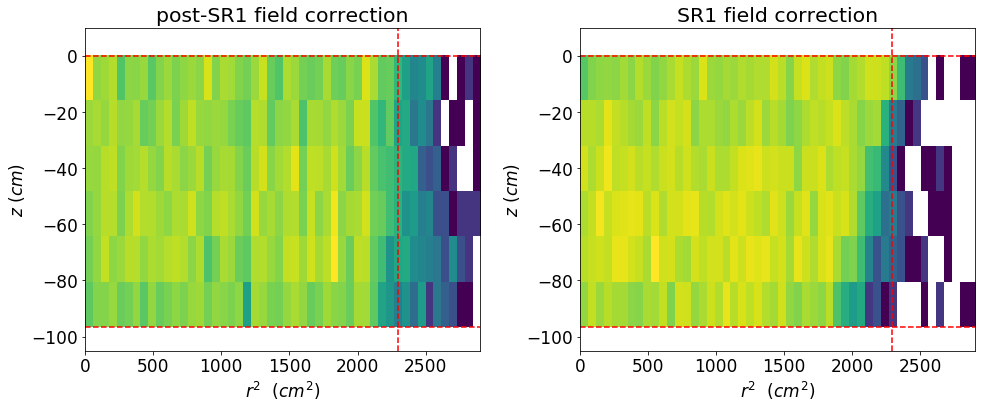

In [79]:
plt.subplot(121)
hist_corretto, xbins_corretto, ybins_corretto, _ = plt.hist2d(data_uniformity['int_a_r_correct']**2, 
                                                              data_uniformity['int_a_z_pax'], bins=(50,6), 
                                                              range=((0,2900),(-96.6, 0)), norm=matplotlib.colors.LogNorm(),
                                                              cmin = 1,alpha = 1)
plt.axvline(x=47.9**2, color='red', ls='--', label='TPC boundary')
plt.axhline(y=0, color='red', ls='--')
plt.axhline(y=-96.6, color='red', ls='--')
plt.ylim(-105,10)
plt.title('post-SR1 field correction')
plt.xlabel('$r^2$  ($cm^2$)')
plt.ylabel('$z$ $(cm)$')
plt.subplot(122)
hist, xbins, ybins, _ = plt.hist2d(data_uniformity['int_a_r_3d_nn']**2, 
                                   data_uniformity['int_a_z_pax'], bins=(50,6), 
                                   range=((0,2900),(-96.6, 0)), norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 1)
plt.axvline(x=47.9**2, color='red', ls='--', label='TPC boundary')
plt.axhline(y=0, color='red', ls='--')
plt.axhline(y=-96.6, color='red', ls='--')
plt.ylim(-105,10)
plt.title('SR1 field correction')
plt.xlabel('$r^2$  ($cm^2$)')
plt.ylabel('$z$ $(cm)$')
plt.savefig('figures/field_distortion_correction.png', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [80]:
hist_tmp1, xbins_tmp1, ybins_tmp1, _ = plt.hist2d(data_uniformity['int_a_r_nn']**2, data_uniformity['int_a_z_pax'], 
                                                  bins=(50,6), range=((0,2900),(-96.6, 0)), 
                                                  norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)
hist_tmp2, xbins_tmp2, ybins_tmp2, _ = plt.hist2d(data_uniformity['int_a_r_correct']**2, 
                                                              data_uniformity['int_a_z_pax'], bins=(50,6), 
                                                              range=((0,2900),(-96.6, 0)), norm=matplotlib.colors.LogNorm(),
                                                              cmin = 1,alpha = 1)
hist_tmp3, xbins_tmp3, ybins_tmp3, _ = plt.hist2d(data_uniformity['int_a_r_3d_nn']**2, 
                                   data_uniformity['int_a_z_pax'], bins=(50,6), 
                                   range=((0,2900),(-96.6, 0)), norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 1)
plt.close()
###############################
NaNs = np.isnan(hist_tmp1)
hist_tmp1[NaNs] = 0
Nans = np.isnan(hist_tmp1)
hist_tmp1[NaNs] = 0
X_tmp1 = [(xbins_tmp1[i+1]+xbins_tmp1[i])/2 for i in range(0, len(xbins_tmp1)-1)]
Z_tmp1 = [(ybins_tmp1[i+1]+ybins_tmp1[i])/2 for i in range(0, len(ybins_tmp1)-1)]
Y_tmp1 = hist_tmp1.transpose()
###############################
NaNs = np.isnan(hist_tmp2)
hist_tmp2[NaNs] = 0
Nans = np.isnan(hist_tmp2)
hist_tmp2[NaNs] = 0
X_tmp2 = [(xbins_tmp2[i+1]+xbins_tmp2[i])/2 for i in range(0, len(xbins_tmp2)-1)]
Z_tmp2 = [(ybins_tmp2[i+1]+ybins_tmp2[i])/2 for i in range(0, len(ybins_tmp2)-1)]
Y_tmp2 = hist_tmp2.transpose()
###############################
NaNs = np.isnan(hist_tmp3)
hist_tmp3[NaNs] = 0
Nans = np.isnan(hist_tmp3)
hist_tmp3[NaNs] = 0
X_tmp3 = [(xbins_tmp3[i+1]+xbins_tmp3[i])/2 for i in range(0, len(xbins_tmp3)-1)]
Z_tmp3 = [(ybins_tmp3[i+1]+ybins_tmp3[i])/2 for i in range(0, len(ybins_tmp3)-1)]
Y_tmp3 = hist_tmp3.transpose()
###############################

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


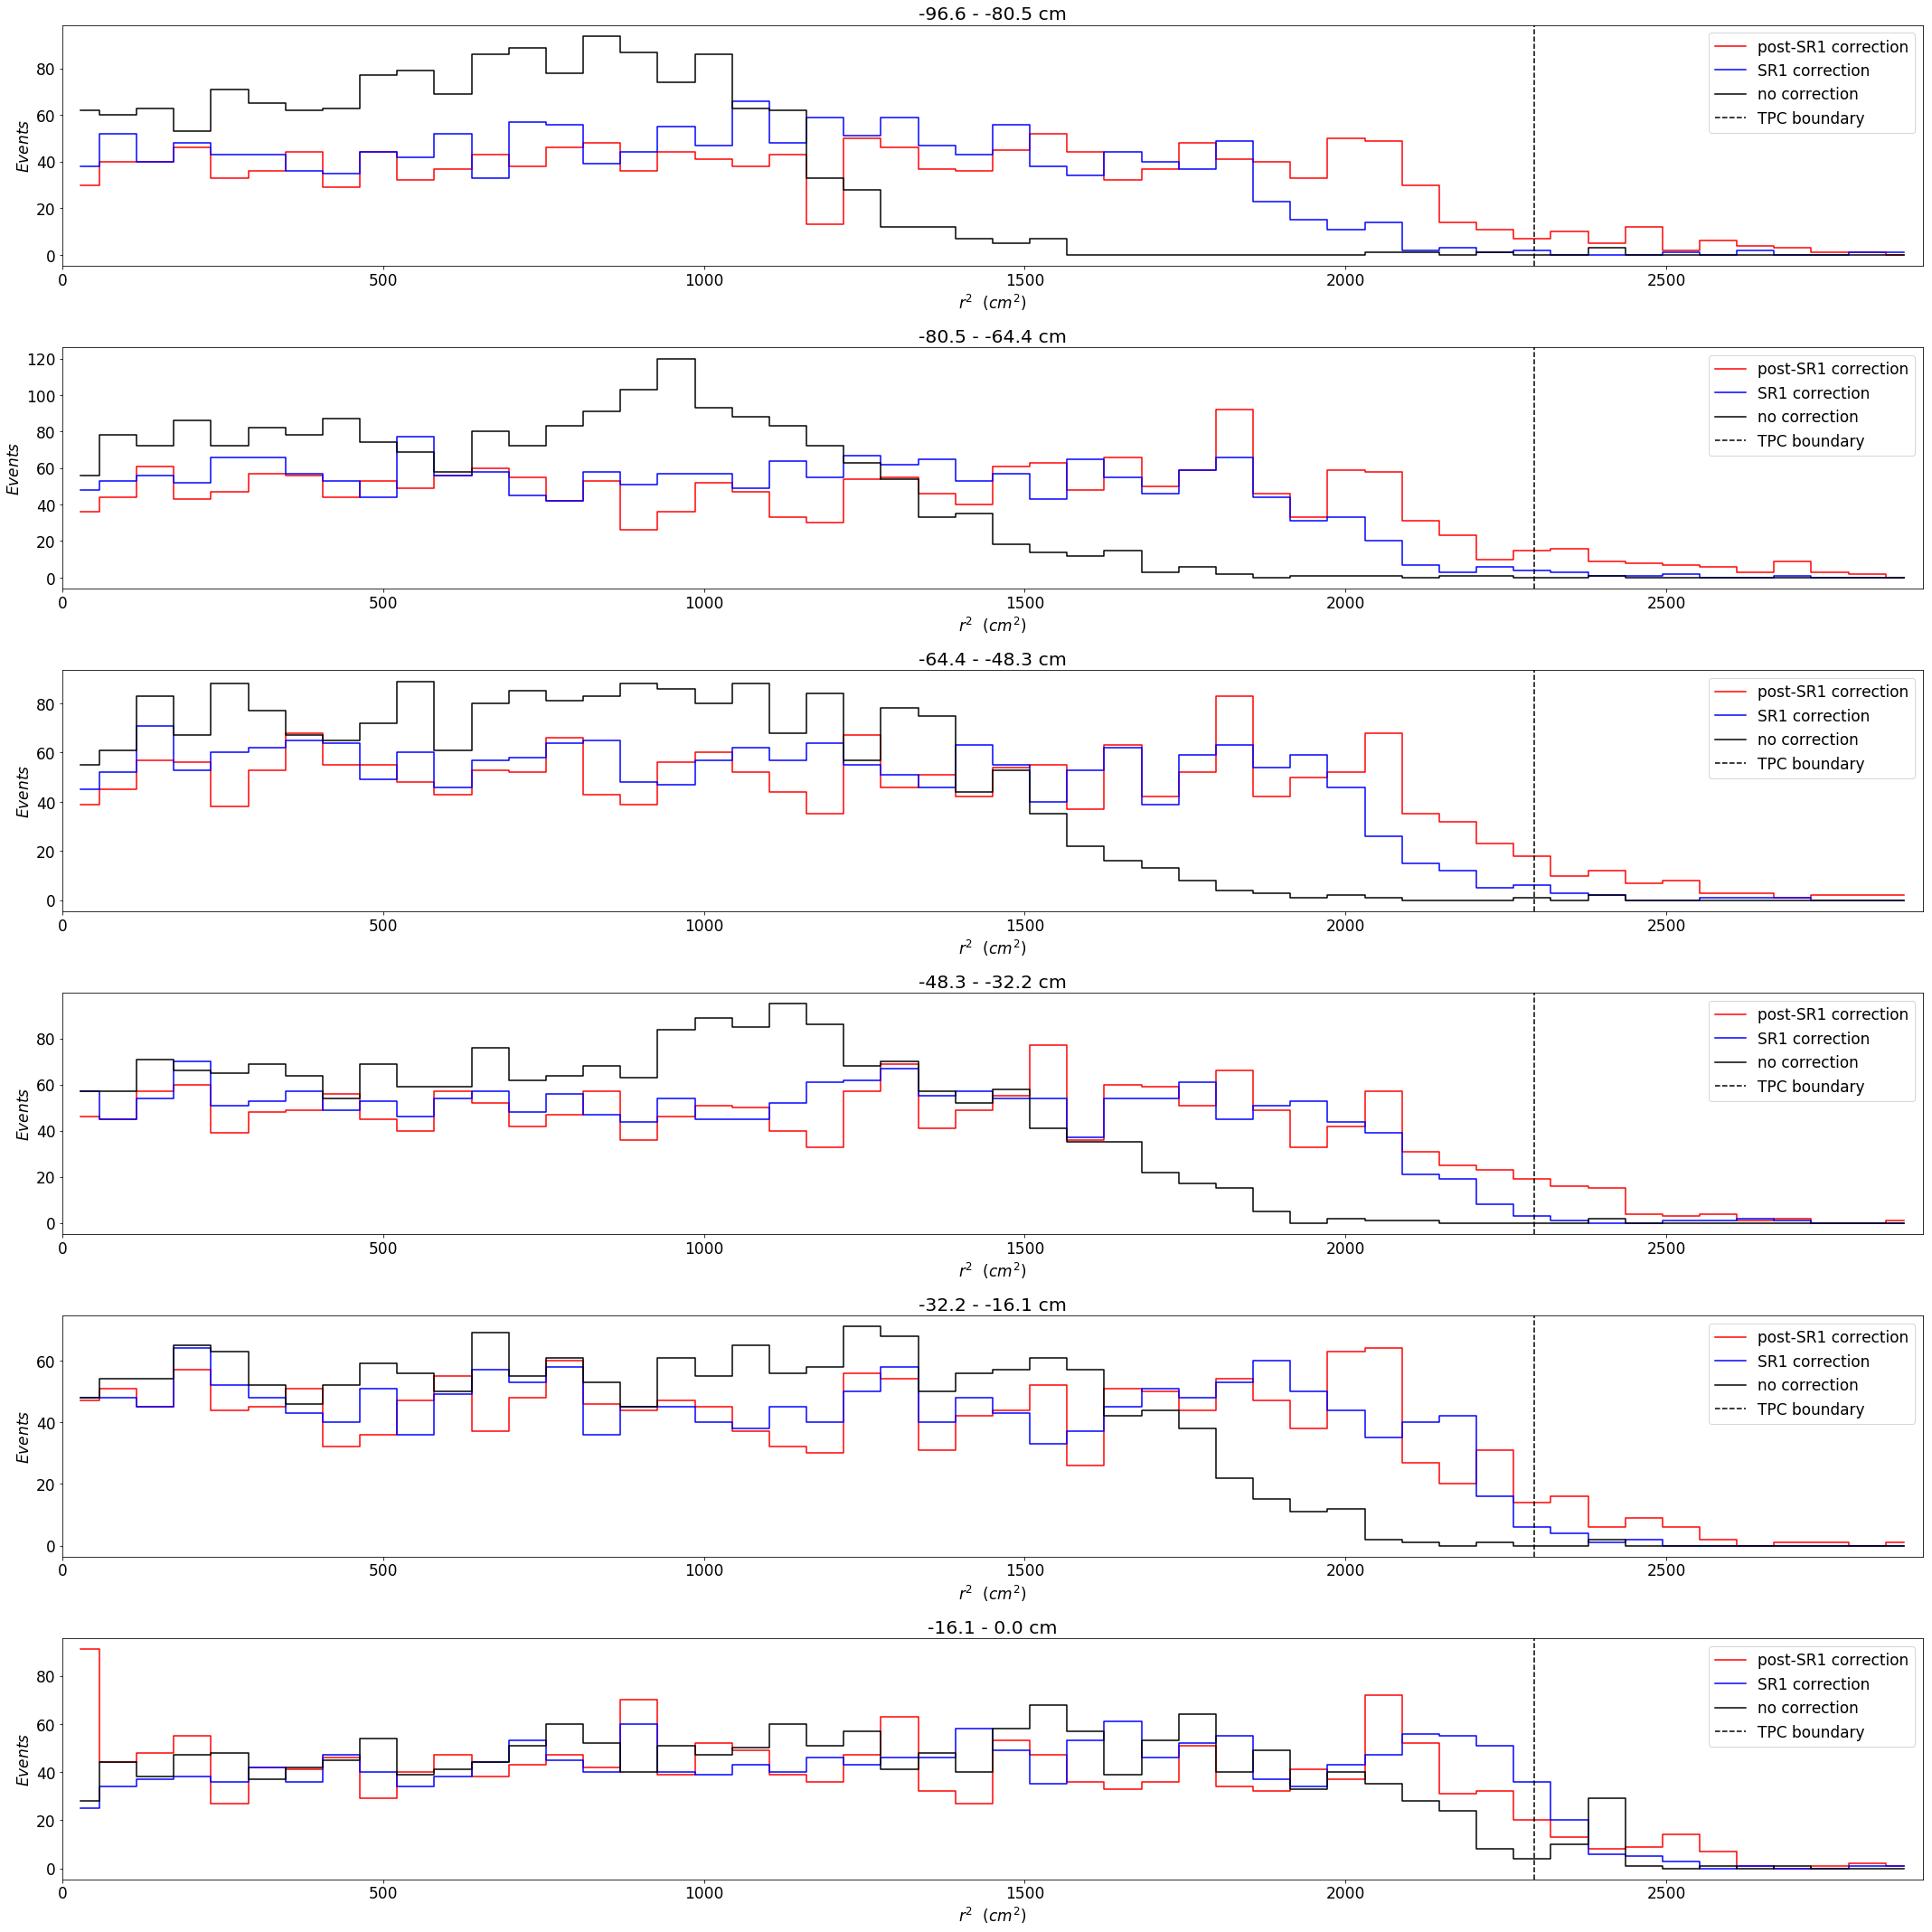

In [81]:
fig, axs = plt.subplots(6,1, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .7, wspace=.1)
axs = axs.ravel()
for i in range(0,6):
    axs[i].step(X_tmp2, Y_tmp2[i], 'r--', where='mid', label='post-SR1 correction')
    axs[i].step(X_tmp3, Y_tmp3[i], 'b--', where='mid', label='SR1 correction')
    axs[i].step(X_tmp1, Y_tmp1[i], 'k--', where='mid', label='no correction')
    axs[i].set_title(str(ybins_corretto[i]) + ' - ' + str(ybins_corretto[i+1]) + ' cm')
    axs[i].axvline(x=47.9**2, color='k', ls='--', label='TPC boundary')
    axs[i].set_xlim(0,2900)
    axs[i].legend(loc='upper right')
    axs[i].set_xlabel('$r^2$  ($cm^2$)')
    axs[i].set_ylabel('$Events$')
plt.savefig('figures/fdc_comparison.png', bbox_inches='tight')
fig.tight_layout()
fig.show()

### --------- Light Efficency Correction ---------

In [26]:
'''plt.plot(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], 
         linestyle='', marker='o', markersize=2, color='red', label='s1_a')
plt.plot(-data_uniformity['int_a_z_pax'], data_uniformity['cs1_a'], 
         linestyle='', marker='o', markersize=2, color='b', label='cs1_a')
plt.xlabel('$-z$ $(cm)$')
plt.ylabel('$s1 [PE]$')
plt.legend(loc='upper left')
plt.ylim(0,500)
plt.close()'''

"plt.plot(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], \n         linestyle='', marker='o', markersize=2, color='red', label='s1_a')\nplt.plot(-data_uniformity['int_a_z_pax'], data_uniformity['cs1_a'], \n         linestyle='', marker='o', markersize=2, color='b', label='cs1_a')\nplt.xlabel('$-z$ $(cm)$')\nplt.ylabel('$s1 [PE]$')\nplt.legend(loc='upper left')\nplt.ylim(0,500)\nplt.close()"

In [27]:
'''plt.plot(data_uniformity['int_a_r_correct'], data_uniformity['s1_a'], 
         linestyle='', marker='o', markersize=2, color='r', label='s1_a')
plt.plot(data_uniformity['int_a_r_correct'], data_uniformity['cs1_a'], 
         linestyle='', marker='o', markersize=2, color='b', label='cs1_a')
plt.axvline(x=47.9, color='k', ls='--', label='TPC boundary')
plt.xlabel('$r$ $(cm)$')
plt.ylabel('$PE$')
plt.legend(loc='best')
plt.ylim(0,500)
plt.xlim(0,50)
plt.close()'''

"plt.plot(data_uniformity['int_a_r_correct'], data_uniformity['s1_a'], \n         linestyle='', marker='o', markersize=2, color='r', label='s1_a')\nplt.plot(data_uniformity['int_a_r_correct'], data_uniformity['cs1_a'], \n         linestyle='', marker='o', markersize=2, color='b', label='cs1_a')\nplt.axvline(x=47.9, color='k', ls='--', label='TPC boundary')\nplt.xlabel('$r$ $(cm)$')\nplt.ylabel('$PE$')\nplt.legend(loc='best')\nplt.ylim(0,500)\nplt.xlim(0,50)\nplt.close()"

In [28]:
'''# S1 < 500 PE
data_uniformity = hax.cuts.selection(data_uniformity, data_uniformity['s1_a'] < 500)'''

"# S1 < 500 PE\ndata_uniformity = hax.cuts.selection(data_uniformity, data_uniformity['s1_a'] < 500)"

In [29]:
'''def gauss(x, N, mu, sigma):
    return N*np.exp(-((x-mu)/(2*sigma))**2)
hist, x, y, _ = plt.hist2d(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], bins=(50,50), 
                           range=((0,96.4),(0, 500)), cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)
plt.close()
# hist: righe->z colonne->s1_a
NaNs = np.isnan(hist)
hist[NaNs] = 0
Nans = np.isnan(hist)
hist[NaNs] = 0
hist_trasp = hist.transpose()
for i in range(0, len(hist_trasp)):
    median.append(np.median(hist_trasp[i]))
X = [(x[i+1]+x[i])/2 for i in range(0, len(x)-1)]
Y = [(y[i+1]+y[i])/2 for i in range(0, len(y)-1)]
N = [0 for i in range(0,len(Y)-1)]
mu = N.copy()
sigma = N.copy()
dN = N.copy()
dmu = N.copy()
dsigma = N.copy()
resids = N.copy()
redchisqr = N.copy()

init1 = [85.0, 180.0, 3.0]
init2 = [85.0, 220.0, 3.0]
init3 = [85.0, 250.0, 3.0]
init4 = [85.0, 290.0, 3.0]
init5 = [85.0, 330.0, 3.0]
for i in range(len(Y)-1):
    if i < 4:
        init = init1
    if i >=4 and i< 16:
        init = init2
    if i >= 16 and i < 24:
        init = init3
    if i >= 24 and i < 42:
        init = init4
    if i >=42:
        init = init5
    popt, pcov = curve_fit(gauss, np.asarray(Y), hist[i], maxfev=1000, p0=init)
    # Unpack fitting parameters and their relative erros
    N[i], mu[i], sigma[i] = popt
    dN[i], dmu[i], dsigma[i] = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
    # Calculate residuals and reduced chi squared
    resids[i] = hist[i] - gauss(np.asarray(Y), *popt)
    redchisqr[i] = ((resids[i]/gauss(np.asarray(Y), *popt))**2).sum()/float(len(X)-3)
    #print('--Parameters-- \nN: (', N[i],' +/- ', dN[i], ') a: (', mu[i], ' +/- ', dmu[i], ') b: (', sigma[i], ' +/- ', dsigma[i], ')\n--Covariance matrix-- \n', pcov)
    #print('Red chi squared: ', redchisqr[i])'''

"def gauss(x, N, mu, sigma):\n    return N*np.exp(-((x-mu)/(2*sigma))**2)\nhist, x, y, _ = plt.hist2d(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], bins=(50,50), \n                           range=((0,96.4),(0, 500)), cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)\nplt.close()\n# hist: righe->z colonne->s1_a\nNaNs = np.isnan(hist)\nhist[NaNs] = 0\nNans = np.isnan(hist)\nhist[NaNs] = 0\nhist_trasp = hist.transpose()\nfor i in range(0, len(hist_trasp)):\n    median.append(np.median(hist_trasp[i]))\nX = [(x[i+1]+x[i])/2 for i in range(0, len(x)-1)]\nY = [(y[i+1]+y[i])/2 for i in range(0, len(y)-1)]\nN = [0 for i in range(0,len(Y)-1)]\nmu = N.copy()\nsigma = N.copy()\ndN = N.copy()\ndmu = N.copy()\ndsigma = N.copy()\nresids = N.copy()\nredchisqr = N.copy()\n\ninit1 = [85.0, 180.0, 3.0]\ninit2 = [85.0, 220.0, 3.0]\ninit3 = [85.0, 250.0, 3.0]\ninit4 = [85.0, 290.0, 3.0]\ninit5 = [85.0, 330.0, 3.0]\nfor i in range(len(Y)-1):\n    if i < 4:\n        init = i

In [30]:
'''for i in range(len(Y)-1):
    #print('\n--------------------------------------------')
    #print('Bin numero: ', i, '\n')
    #print('--Parameters-- \nN: (', N[i],' +/- ', dN[i], ') mu: (', mu[i], ' +/- ', dmu[i], ') sigma: (', sigma[i], ' +/- ', dsigma[i], ')')
    #print('Red chi squared: ', redchisqr[i]) 
    plt.subplot(211)
    plt.plot(Y, hist[i], color='blue')
    plt.plot(Y, gauss(np.asarray(Y), N[i], mu[i], sigma[i]), color='darkorange')
    if i < 4:
        init = init1
    if i >=4 and i< 16:
        init = init2
    if i >= 16 and i < 24:
        init = init3
    if i >= 24 and i < 42:
        init = init4
    if i >=42:
        init = init5
    plt.plot(Y, gauss(np.asarray(Y), *init), color='k')
    plt.subplot(212)
    plt.plot(Y, resids[i], linestyle='-', marker='o', color='darkorange' )
    plt.axhline(y=0, color='k', ls='--')
    #plt.show()
    #print('--------------------------------------------\n')
plt.close()'''

"for i in range(len(Y)-1):\n    #print('\n--------------------------------------------')\n    #print('Bin numero: ', i, '\n')\n    #print('--Parameters-- \nN: (', N[i],' +/- ', dN[i], ') mu: (', mu[i], ' +/- ', dmu[i], ') sigma: (', sigma[i], ' +/- ', dsigma[i], ')')\n    #print('Red chi squared: ', redchisqr[i]) \n    plt.subplot(211)\n    plt.plot(Y, hist[i], color='blue')\n    plt.plot(Y, gauss(np.asarray(Y), N[i], mu[i], sigma[i]), color='darkorange')\n    if i < 4:\n        init = init1\n    if i >=4 and i< 16:\n        init = init2\n    if i >= 16 and i < 24:\n        init = init3\n    if i >= 24 and i < 42:\n        init = init4\n    if i >=42:\n        init = init5\n    plt.plot(Y, gauss(np.asarray(Y), *init), color='k')\n    plt.subplot(212)\n    plt.plot(Y, resids[i], linestyle='-', marker='o', color='darkorange' )\n    plt.axhline(y=0, color='k', ls='--')\n    #plt.show()\n    #print('--------------------------------------------\n')\nplt.close()"

In [31]:
'''def LCE(z, a, b, c, d, e):
    return a + b*z + c*z**2 + d*z**3 + e*z**4

init = [200, 1.1, 0,0,0]
popt, pcov = curve_fit(LCE, np.asarray(X[:49]), mu, maxfev=1000, p0=init)
a, b, c, d, e = popt
da, db, dc, dd, de = [np.sqrt(pcov[j,j]) for j in range(popt.size)]
# Calculate residuals and reduced chi squared
resids = mu - LCE(np.asarray(X[:49]), *popt)
redchisqr = ((resids/LCE(np.asarray(X[:49]), *popt))**2).sum()/float(len(X[:49])-3)
#print('--Parameters--: ')
#print(a, da, '\n', b, db, '\n', c, dc, '\n', d, dd, '\n', e, de, '\n')
#print('\n--Covariance matrix--\n', pcov)
#print('Red chi squared: ', redchisqr)

mu_mean = np.mean(mu)

plt.hist2d(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], bins=(50,50), 
                           range=((0,96.4),(0, 500)), cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)
plt.colorbar(label='Selected Krypton events')
plt.ylabel('$s1_a$ $[PE]$')
plt.xlabel('$z$ $(cm)$')
plt.axvline(x=92.9, color='k', ls='--', label='Fiducial volume')
plt.axvline(x=9, color='k', ls='--')
plt.axhline(y=mu_mean, color='k', ls='--')
plt.plot(X[:49], mu, linestyle='--', marker='o', color='darkgrey')
plt.plot(X[:49], LCE(np.asarray(X[:49]), *popt), color='darkgrey')
plt.legend(loc='upper left')


'''

"def LCE(z, a, b, c, d, e):\n    return a + b*z + c*z**2 + d*z**3 + e*z**4\n\ninit = [200, 1.1, 0,0,0]\npopt, pcov = curve_fit(LCE, np.asarray(X[:49]), mu, maxfev=1000, p0=init)\na, b, c, d, e = popt\nda, db, dc, dd, de = [np.sqrt(pcov[j,j]) for j in range(popt.size)]\n# Calculate residuals and reduced chi squared\nresids = mu - LCE(np.asarray(X[:49]), *popt)\nredchisqr = ((resids/LCE(np.asarray(X[:49]), *popt))**2).sum()/float(len(X[:49])-3)\n#print('--Parameters--: ')\n#print(a, da, '\n', b, db, '\n', c, dc, '\n', d, dd, '\n', e, de, '\n')\n#print('\n--Covariance matrix--\n', pcov)\n#print('Red chi squared: ', redchisqr)\n\nmu_mean = np.mean(mu)\n\nplt.hist2d(-data_uniformity['int_a_z_pax'], data_uniformity['s1_a'], bins=(50,50), \n                           range=((0,96.4),(0, 500)), cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)\nplt.colorbar(label='Selected Krypton events')\nplt.ylabel('$s1_a$ $[PE]$')\nplt.xlabel('$z$ $(cm)$')\nplt.axvline(x=92.9, color='k